# Analyzing TCR data
![dandelion_logo](img/dandelion_logo_illustration.png)

With `dandelion>=1.3` onwards, there will be the ability to start analyzing 10x single-cell TCR data with the existing setup for both alpha-beta and gamma-delta TCR data formats. Currently, the alpha-beta and gamma-delta data sets have to be analyzed separately.

The workflow may be a bit buggy because it's not optimised for TCR data; do let me know if you find any bugs and I can see if i can try to fix the issue(s).

We will download the various input formats of TCR files from 10x's [resource page](https://www.10xgenomics.com/resources/datasets) as part of this tutorial:

```bash
# bash
mkdir -p dandelion_tutorial/sc5p_v2_hs_PBMC_10k;
mkdir -p dandelion_tutorial/sc5p_v1p1_hs_melanoma_10k;

cd dandelion_tutorial/sc5p_v2_hs_PBMC_10k;
wget https://cf.10xgenomics.com/samples/cell-vdj/4.0.0/sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_filtered_feature_bc_matrix.h5;
wget https://cf.10xgenomics.com/samples/cell-vdj/4.0.0/sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_t_airr_rearrangement.tsv;
wget https://cf.10xgenomics.com/samples/cell-vdj/4.0.0/sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_t_filtered_contig_annotations.csv;
wget https://cf.10xgenomics.com/samples/cell-vdj/4.0.0/sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_t_filtered_contig.fasta;

cd ../sc5p_v1p1_hs_melanoma_10k;
wget https://cf.10xgenomics.com/samples/cell-vdj/4.0.0/sc5p_v1p1_hs_melanoma_10k/sc5p_v1p1_hs_melanoma_10k_filtered_feature_bc_matrix.h5;
wget https://cf.10xgenomics.com/samples/cell-vdj/4.0.0/sc5p_v1p1_hs_melanoma_10k/sc5p_v1p1_hs_melanoma_10k_t_airr_rearrangement.tsv;
wget https://cf.10xgenomics.com/samples/cell-vdj/4.0.0/sc5p_v1p1_hs_melanoma_10k/sc5p_v1p1_hs_melanoma_10k_t_filtered_contig_annotations.csv;
wget https://cf.10xgenomics.com/samples/cell-vdj/4.0.0/sc5p_v1p1_hs_melanoma_10k/sc5p_v1p1_hs_melanoma_10k_t_filtered_contig.fasta;
```

**Import *dandelion* module**

In [1]:
import os
import dandelion as ddl
# change directory to somewhere more workable
os.chdir(os.path.expanduser('/Users/kt16/Downloads/dandelion_tutorial/'))
ddl.logging.print_versions()

dandelion==0.2.4.dev78 pandas==1.4.2 numpy==1.21.6 matplotlib==3.5.2 networkx==2.8.4 scipy==1.8.1


I'm showing two examples for reading in the data: with or without reannotation.

**Read in AIRR format**

In [2]:
# read in the airr_rearrangement.tsv file
file1 = 'sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_t_airr_rearrangement.tsv'
file2 = 'sc5p_v1p1_hs_melanoma_10k/sc5p_v1p1_hs_melanoma_10k_t_airr_rearrangement.tsv'

In [3]:
vdj1 = ddl.read_10x_airr(file1)
vdj1

Dandelion class object with n_obs = 5351 and n_contigs = 10860
    data: 'cell_id', 'sequence_id', 'sequence', 'sequence_aa', 'productive', 'rev_comp', 'v_call', 'v_cigar', 'd_call', 'd_cigar', 'j_call', 'j_cigar', 'c_call', 'c_cigar', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'junction_length', 'junction_aa_length', 'v_sequence_start', 'v_sequence_end', 'd_sequence_start', 'd_sequence_end', 'j_sequence_start', 'j_sequence_end', 'c_sequence_start', 'c_sequence_end', 'consensus_count', 'duplicate_count', 'is_cell', 'locus', 'rearrangement_status'
    metadata: 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_abT_VDJ', 'd_call_abT_VDJ', 'j_call_abT_VDJ', 'v_call_abT_VJ', 'j_call_abT_VJ', 'productive_abT_VDJ', 'productive_abT_VJ', 'duplicate_count_abT_VDJ', 'duplicate_count_abT_VJ'

In [4]:
vdj2 = ddl.read_10x_airr(file2)
vdj2

Dandelion class object with n_obs = 1560 and n_contigs = 2755
    data: 'cell_id', 'sequence_id', 'sequence', 'sequence_aa', 'productive', 'rev_comp', 'v_call', 'v_cigar', 'd_call', 'd_cigar', 'j_call', 'j_cigar', 'c_call', 'c_cigar', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'junction_length', 'junction_aa_length', 'v_sequence_start', 'v_sequence_end', 'd_sequence_start', 'd_sequence_end', 'j_sequence_start', 'j_sequence_end', 'c_sequence_start', 'c_sequence_end', 'consensus_count', 'duplicate_count', 'is_cell', 'locus', 'rearrangement_status'
    metadata: 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_abT_VDJ', 'd_call_abT_VDJ', 'j_call_abT_VDJ', 'v_call_abT_VJ', 'j_call_abT_VJ', 'productive_abT_VDJ', 'productive_abT_VJ', 'duplicate_count_abT_VDJ', 'duplicate_count_abT_VJ',

In [5]:
# combine into a singular object
# let's add the sample_id to each cell barcode so that we don't end up overlapping later on
sample_id = 'sc5p_v2_hs_PBMC_10k'
vdj1.data['sample_id'] = sample_id
vdj1.data['cell_id'] = [sample_id + '_' + c for c in vdj1.data['cell_id']]
vdj1.data['sequence_id'] = [sample_id + '_' + s for s in vdj1.data['sequence_id']]

sample_id = 'sc5p_v1p1_hs_melanoma_10k'
vdj2.data['sample_id'] = sample_id
vdj2.data['cell_id'] = [sample_id + '_' + c for c in vdj2.data['cell_id']]
vdj2.data['sequence_id'] = [sample_id + '_' + s for s in vdj2.data['sequence_id']]

# combine into a singular object
vdj = ddl.concat([vdj1, vdj2])
vdj

Dandelion class object with n_obs = 6911 and n_contigs = 13615
    data: 'cell_id', 'sequence_id', 'sequence', 'sequence_aa', 'productive', 'rev_comp', 'v_call', 'v_cigar', 'd_call', 'd_cigar', 'j_call', 'j_cigar', 'c_call', 'c_cigar', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'junction_length', 'junction_aa_length', 'v_sequence_start', 'v_sequence_end', 'd_sequence_start', 'd_sequence_end', 'j_sequence_start', 'j_sequence_end', 'c_sequence_start', 'c_sequence_end', 'consensus_count', 'duplicate_count', 'is_cell', 'locus', 'rearrangement_status', 'sample_id'
    metadata: 'sample_id', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_abT_VDJ', 'd_call_abT_VDJ', 'j_call_abT_VDJ', 'v_call_abT_VJ', 'j_call_abT_VJ', 'productive_abT_VDJ', 'productive_abT_VJ', 'duplicate_count_abT_VDJ'

**Read in with reannotation**

We specify the `filename_prefix` option because they have different prefixes that precedes `_contig.fasta` and `_contig_annotations.csv`.

In [6]:
samples = ['sc5p_v2_hs_PBMC_10k', 'sc5p_v1p1_hs_melanoma_10k']
filename_prefixes = ['sc5p_v2_hs_PBMC_10k_t_filtered', 'sc5p_v1p1_hs_melanoma_10k_t_filtered']
ddl.pp.format_fastas(samples, prefix = samples, filename_prefix = filename_prefixes)

Formating fasta(s) : 100%|██████████| 2/2 [00:04<00:00,  2.11s/it]                                                                               


Make sure to toggle `loci = 'tr'` for TCR data. I'm setting `reassign_dj = True` so as to try and force a reassignment of J genes (and D genes if it can) with stricter cut offs.

In [7]:
ddl.pp.reannotate_genes(samples, loci = 'tr', reassign_dj = True, filename_prefix = filename_prefixes)

Assigning genes :   0%|          | 0/2 [00:00<?, ?it/s]                                                                                          

         START> MakeDB
       COMMAND> igblast
  ALIGNER_FILE> sc5p_v2_hs_PBMC_10k_t_filtered_contig_igblast.fmt7
      SEQ_FILE> sc5p_v2_hs_PBMC_10k_t_filtered_contig.fasta
       ASIS_ID> False
    ASIS_CALLS> False
       PARTIAL> False
      EXTENDED> True
INFER_JUNCTION> False

PROGRESS> 09:44:07 |Done                | 0.0 min

PROGRESS> 09:44:22 |####################| 100% (13,630) 0.2 min

OUTPUT> sc5p_v2_hs_PBMC_10k_t_filtered_contig_igblast_db-pass.tsv
  PASS> 12246
  FAIL> 1384
   END> MakeDb

         START> MakeDB
       COMMAND> igblast
  ALIGNER_FILE> sc5p_v2_hs_PBMC_10k_t_filtered_contig_igblast.fmt7
      SEQ_FILE> sc5p_v2_hs_PBMC_10k_t_filtered_contig.fasta
       ASIS_ID> False
    ASIS_CALLS> False
       PARTIAL> False
      EXTENDED> True
INFER_JUNCTION> False

PROGRESS> 09:44:22 |Done                | 0.0 min

PROGRESS> 09:44:35 |####################| 100% (13,630) 0.2 min

OUTPUT> sc5p_v2_hs_PBMC_10k_t_filtered_contig_igblast_db-pass.tsv
  PASS> 12246
  FAIL> 138

Assigning genes :  50%|█████     | 1/2 [06:07<06:07, 367.16s/it]                                                                                 

         START> MakeDB
       COMMAND> igblast
  ALIGNER_FILE> sc5p_v1p1_hs_melanoma_10k_t_filtered_contig_igblast.fmt7
      SEQ_FILE> sc5p_v1p1_hs_melanoma_10k_t_filtered_contig.fasta
       ASIS_ID> False
    ASIS_CALLS> False
       PARTIAL> False
      EXTENDED> True
INFER_JUNCTION> False

PROGRESS> 09:46:12 |Done                | 0.0 min

PROGRESS> 09:46:18 |####################| 100% (3,706) 0.1 min

OUTPUT> sc5p_v1p1_hs_melanoma_10k_t_filtered_contig_igblast_db-pass.tsv
  PASS> 3217
  FAIL> 489
   END> MakeDb

         START> MakeDB
       COMMAND> igblast
  ALIGNER_FILE> sc5p_v1p1_hs_melanoma_10k_t_filtered_contig_igblast.fmt7
      SEQ_FILE> sc5p_v1p1_hs_melanoma_10k_t_filtered_contig.fasta
       ASIS_ID> False
    ASIS_CALLS> False
       PARTIAL> False
      EXTENDED> True
INFER_JUNCTION> False

PROGRESS> 09:46:19 |Done                | 0.0 min

PROGRESS> 09:46:25 |####################| 100% (3,706) 0.1 min

OUTPUT> sc5p_v1p1_hs_melanoma_10k_t_filtered_contig_igblast_db-pa

Assigning genes : 100%|██████████| 2/2 [07:40<00:00, 230.43s/it]                                                                                 


building file list ... done
sc5p_v2_hs_PBMC_10k_t_filtered_contig_igblast_db-pass.tsv

sent 5.11M bytes  received 42 bytes  2.05M bytes/sec
total size is 32.04M  speedup is 6.26
building file list ... done
sc5p_v1p1_hs_melanoma_10k_t_filtered_contig_igblast_db-pass.tsv

sent 1.32M bytes  received 42 bytes  883.17K bytes/sec
total size is 8.42M  speedup is 6.36


There's no need to run the the rest of the preprocessing steps.

We'll read in the reannotated files like as follow:

In [8]:
import pandas as pd
tcr_files = []
for sample in samples:
    file_location = sample +'/dandelion/' + sample + '_t_filtered_contig_dandelion.tsv'
    tcr_files.append(pd.read_csv(file_location, sep = '\t'))
tcr = tcr_files[0].append(tcr_files[1:])
tcr.reset_index(inplace = True, drop = True)
tcr

/var/folders/nb/wrd6px6171j52lqpmkljt6vw000l2l/T/ipykernel_44286/552048275.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,sequence_id,sequence,rev_comp,productive,v_call,d_call,j_call,sequence_alignment,germline_alignment,junction,...,fwr2_aa,fwr3_aa,fwr4_aa,cdr1_aa,cdr2_aa,cdr3_aa,sequence_alignment_aa,v_sequence_alignment_aa,d_sequence_alignment_aa,j_sequence_alignment_aa
0,sc5p_v2_hs_PBMC_10k_AAACCTGAGCGATAGC_contig_1,CTGGAAGACCACCTGGGCTGTCATTGAGCTCTGGTGCCAGGAGGAA...,F,T,TRAV23/DV6*02,NaN,TRAJ22*01,CAGCAGCAGGTGAAACAAAGTCCTCAATCTTTGATAGTCCAGAAAG...,CAGCAGCAGGTGAAACAAAGTCCTCAATCTTTGATAGTCCAGAAAG...,TGTGCAGCAAGCAAGGGTTCTGCAAGGCAACTGACCTTT,...,FPWYQQFPGKGPALLIA,KKEGRFTISFNKSAKQFSLHIMDSQPGDSATYFC,FGSGTQLTVLP,NTAFDY,IRPDVSE,AASKGSARQLT,QQQVKQSPQSLIVQKGGIPIINCAYENTAFDYFPWYQQFPGKGPAL...,QQQVKQSPQSLIVQKGGIPIINCAYENTAFDYFPWYQQFPGKGPAL...,NaN,GSARQLTFGSGTQLTVLP
1,sc5p_v2_hs_PBMC_10k_AAACCTGAGCGATAGC_contig_2,GAGAGTCCTGCTCCCCTTTCATCAATGCACAGATACAGAAGACCCC...,F,T,TRBV6-5*01,NaN,TRBJ2-3*01,AATGCTGGTGTCACTCAGACCCCAAAATTCCAGGTCCTGAAGACAG...,AATGCTGGTGTCACTCAGACCCCAAAATTCCAGGTCCTGAAGACAG...,TGTGCCAGCAGTTACCGGGGGGGATCGGAAGATACGCAGTATTTT,...,MSWYRQDPGMGLRLIHY,TDQGEVPNGYNVSRSTTEDFPLRLLSAAPSQTSVYFC,FGPGTRLTVL,MNHEY,SVGAGI,ASSYRGGSEDTQY,NAGVTQTPKFQVLKTGQSMTLQCAQDMNHEYMSWYRQDPGMGLRLI...,NAGVTQTPKFQVLKTGQSMTLQCAQDMNHEYMSWYRQDPGMGLRLI...,NaN,DTQYFGPGTRLTVL
2,sc5p_v2_hs_PBMC_10k_AAACCTGAGTCACGCC_contig_2,CCTTTTCACCAATGCACAGACCCAGAGGACCCCTCCATCCTGCAGT...,F,T,"TRBV6-2*01,TRBV6-3*01",NaN,TRBJ2-6*01,AATGCTGGTGTCACTCAGACCCCAAAATTCCGGGTCCTGAAGACAG...,AATGCTGGTGTCACTCAGACCCCAAAATTCCGGGTCCTGAAGACAG...,TGTGCCAGCAGTTATCTCCCCCGTAGACAGGACAGGGAATCCTCTG...,...,MYWYRQDPGMGLRLIHY,TAKGEVPDGYNVSRLKKQNFLLGLESAAPSQTSVYFC,FGAGSRLTVL,MNHEY,SVGEGT,ASSYLPRRQDRESSGANVLT,NAGVTQTPKFRVLKTGQSMTLLCAQDMNHEYMYWYRQDPGMGLRLI...,NAGVTQTPKFRVLKTGQSMTLLCAQDMNHEYMYWYRQDPGMGLRLI...,NaN,SGANVLTFGAGSRLTVL
3,sc5p_v2_hs_PBMC_10k_AAACCTGAGTCACGCC_contig_1,GTAGCTCGTTGATATCTGTGTGGATAGGGAGCTGTGACGAGGGCAA...,F,T,TRAV8-6*02,NaN,TRAJ8*01,GCCCAGTCTGTGACCCAGCTTGACAGCCAAGTCCCTGTCTTTGAAG...,GCCCAGTCTGTGACCCAGCTTGACAGCCAAGTCCCTGTCTTTGAAG...,TGTGCTGTGAGTGCGTTTTTTCAGAAACTTGTATTT,...,LFWYVQYPNQGLQLLLK,KGINGFEAEFNKSQTSFHLRKPSVHISDTAEYFC,FGTGTRLLVSP,SSVSVY,YLSGSTLV,AVSAFFQKLV,AQSVTQLDSQVPVFEEAPVELRCNYSSSVSVYLFWYVQYPNQGLQL...,AQSVTQLDSQVPVFEEAPVELRCNYSSSVSVYLFWYVQYPNQGLQL...,NaN,FQKLVFGTGTRLLVSP
4,sc5p_v2_hs_PBMC_10k_AAACCTGCACGTCAGC_contig_1,CCCACATGAAGTGTCTACCTTCTGCAGACTCCAATGGCTCAGGAAC...,F,T,TRAV1-2*01,NaN,TRAJ33*01,GGACAAAACATTGACCAG...CCCACTGAGATGACAGCTACGGAAG...,GGACAAAACATTGACCAG...CCCACTGAGATGACAGCTACGGAAG...,TGTGCTGTCATGGATAGCAACTATCAGTTAATCTGG,...,LFWYQQHAGEAPTFLSY,EEKGRFSSFLSRSKGYSYLLLKELQMKDSASYLC,WGAGTKLIIKP,TSGFNG,NVLDGL,AVMDSNYQLI,GQNIDQPTEMTATEGAIVQINCTYQTSGFNGLFWYQQHAGEAPTFL...,GQNIDQPTEMTATEGAIVQINCTYQTSGFNGLFWYQQHAGEAPTFL...,NaN,DSNYQLIWGAGTKLIIKP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15458,sc5p_v1p1_hs_melanoma_10k_TTTGGTTTCACAGGCC_con...,AATGGCTCAGGAACTGGGAATGCAGTGCCAGGCTCGTGGTATCCTG...,F,T,TRAV1-2*01,NaN,TRAJ20*01,GGACAAAACATTGACCAG...CCCACTGAGATGACAGCTACGGAAG...,GGACAAAACATTGACCAG...CCCACTGAGATGACAGCTACGGAAG...,TGTGCTGTGATGGGGGACTACAAGCTCAGCTTT,...,LFWYQQHAGEAPTFLSY,EEKGRFSSFLSRSKGYSYLLLKELQMKDSASYLC,FGAGTTVTVRA,TSGFNG,NVLDGL,AVMGDYKLS,GQNIDQPTEMTATEGAIVQINCTYQTSGFNGLFWYQQHAGEAPTFL...,GQNIDQPTEMTATEGAIVQINCTYQTSGFNGLFWYQQHAGEAPTFL...,NaN,DYKLSFGAGTTVTVRA
15459,sc5p_v1p1_hs_melanoma_10k_TTTGGTTTCTTTACGT_con...,TTCCTCTGCTCTGGCAGCAGATCTCCCAGAGGGAGCAGCCTGACCA...,F,T,TRBV30*01,NaN,TRBJ2-5*01,TCTCAGACTATTCATCAATGGCCAGCGACCCTGGTGCAGCCTGTGG...,TCTCAGACTATTCATCAATGGCCAGCGACCCTGGTGCAGCCTGTGG...,TGTGCCTGGAGTGAGCTAGCGGCCCAAGAGACCCAGTACTTC,...,LYWYRQAAGRGLQLLFY,QISSEVPQNLSASRPQDRQFILSSKKLLLSDSGFYLC,FGPGTRLLVL,GTSNPN,SVGIG,AWSELAAQETQY,SQTIHQWPATLVQPVGSPLSLECTVEGTSNPNLYWYRQAAGRGLQL...,SQTIHQWPATLVQPVGSPLSLECTVEGTSNPNLYWYRQAAGRGLQL...,NaN,QETQYFGPGTRLLVL
15460,sc5p_v1p1_hs_melanoma_10k_TTTGGTTTCTTTACGT_con...,GATCTTAATTGGGAAGAACAAGGATGACATCCATTCGAGCTGTATT...,F,F,TRAV13-1*02,NaN,TRAJ43*01,GGAGAGAATGTGGAGCAGCATCCTTCAACCCTGAGTGTCCAGGAGG...,GGAGAGAATGTGGAGCAGCATCCTTCAACCCTG

The reannotated file can be used with dandelion as per the BCR tutorial.

For the rest of the tutorial, I'm going to show how to proceed with 10x's AIRR format file instead as there are some minor differences.

**Import modules for use with scanpy**

In [9]:
import pandas as pd
import numpy as np
import scanpy as sc
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata as ad

warnings.filterwarnings('ignore')
sc.logging.print_header()

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.6 scipy==1.8.1 pandas==1.4.2 scikit-learn==1.1.1 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7


**Import the transcriptome data**

In [10]:
gex_files = {    
    'sc5p_v2_hs_PBMC_10k':'sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_filtered_feature_bc_matrix.h5',
    'sc5p_v1p1_hs_melanoma_10k':'sc5p_v1p1_hs_melanoma_10k/sc5p_v1p1_hs_melanoma_10k_filtered_feature_bc_matrix.h5'
}

In [11]:
adata_list = []
for f in gex_files:
    adata_tmp = sc.read_10x_h5(gex_files[f], gex_only=True)
    adata_tmp.obs['sample_id'] = f
    adata_tmp.obs_names = [f + '_' + x for x in adata_tmp.obs_names]
    adata_tmp.var_names_make_unique()
    adata_list.append(adata_tmp)
adata = ad.concat(adata_list)
adata

AnnData object with n_obs × n_vars = 17275 × 36601
    obs: 'sample_id'

**Run QC on the transcriptome data.**

In [12]:
ddl.pp.recipe_scanpy_qc(adata)
adata

AnnData object with n_obs × n_vars = 17275 × 36601
    obs: 'sample_id', 'scrublet_score', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'is_doublet', 'filter_rna'

**Filtering TCR data.**

Note that I'm using the `Dandelion` object as input rather than the pandas dataframe (yes both types of input will works. In fact, a file path to the .tsv will work too).

In [13]:
# The function will return both objects. 
vdj, adata = ddl.pp.filter_contigs(vdj, adata) # please look at the other tutorials for using `ddl.pp.check_contigs` as well

Preparing data: 13615it [00:02, 6238.54it/s]
Scanning for poor quality/ambiguous contigs: 100%|██████████| 6911/6911 [00:23<00:00, 298.76it/s]                                                


**Check the output V(D)J table**

In [14]:
vdj

Dandelion class object with n_obs = 5336 and n_contigs = 10357
    data: 'cell_id', 'sequence_id', 'sequence', 'sequence_aa', 'productive', 'rev_comp', 'v_call', 'v_cigar', 'd_call', 'd_cigar', 'j_call', 'j_cigar', 'c_call', 'c_cigar', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'junction_length', 'junction_aa_length', 'v_sequence_start', 'v_sequence_end', 'd_sequence_start', 'd_sequence_end', 'j_sequence_start', 'j_sequence_end', 'c_sequence_start', 'c_sequence_end', 'consensus_count', 'duplicate_count', 'is_cell', 'locus', 'rearrangement_status', 'sample_id'
    metadata: 'sample_id', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_abT_VDJ', 'd_call_abT_VDJ', 'j_call_abT_VDJ', 'v_call_abT_VJ', 'j_call_abT_VJ', 'productive_abT_VDJ', 'productive_abT_VJ', 'duplicate_count_abT_VDJ'

**Check the AnnData object as well**

In [15]:
adata

AnnData object with n_obs × n_vars = 17275 × 36601
    obs: 'sample_id', 'scrublet_score', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'is_doublet', 'filter_rna', 'has_contig', 'filter_contig_quality', 'filter_contig_VDJ', 'filter_contig_VJ', 'contig_QC_pass', 'filter_contig'

**The number of cells that actually has a matching BCR can be tabluated.**

In [16]:
pd.crosstab(adata.obs['has_contig'], adata.obs['filter_contig'])

filter_contig,False,True
has_contig,,
No_contig,6949,3478
True,5441,1407


In [17]:
pd.crosstab(adata.obs['has_contig'], adata.obs['contig_QC_pass'])

contig_QC_pass,False,No_contig,True
has_contig,,,
No_contig,0,10427,0
True,1512,0,5336


In [18]:
pd.crosstab(adata.obs['contig_QC_pass'], adata.obs['filter_contig'])

filter_contig,False,True
contig_QC_pass,,
False,105,1407
No_contig,6949,3478
True,5336,0


**Now actually filter the AnnData object and run through a standard workflow starting by filtering genes and normalizing the data**

Because the 'filtered' `AnnData` object was returned as a filtered but otherwise unprocessed object, we still need to normalize and run through the usual process here. The following is just a standard scanpy workflow.

In [19]:
# filter genes
sc.pp.filter_genes(adata, min_cells=3)
# Normalize the counts
sc.pp.normalize_total(adata, target_sum=1e4)
# Logarithmize the data
sc.pp.log1p(adata)
# Stash the normalised counts
adata.raw = adata

**Identify highly-variable genes**

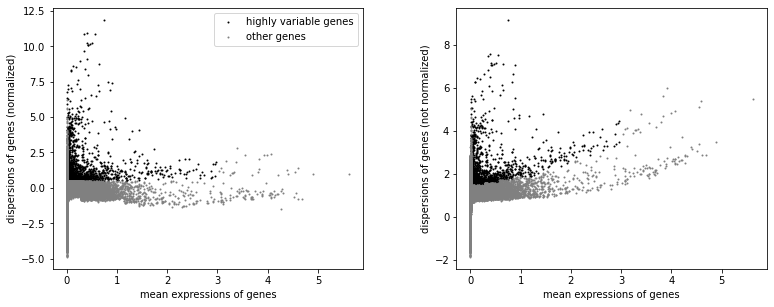

In [20]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

**Filter the genes to only those marked as highly-variable**

In [21]:
adata = adata[:, adata.var.highly_variable]

**Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.**

In [22]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

**Run PCA**

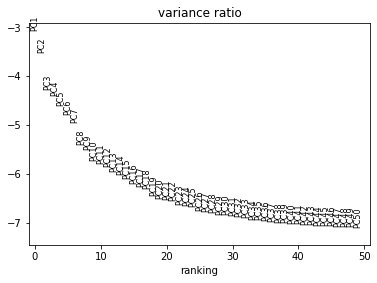

In [23]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

**Computing the neighborhood graph, umap and clusters**

In [24]:
# Computing the neighborhood graph
sc.pp.neighbors(adata)
# Embedding the neighborhood graph
sc.tl.umap(adata)
# Clustering the neighborhood graph
sc.tl.leiden(adata)

**Visualizing the clusters and whether or not there's a corresponding contig**.

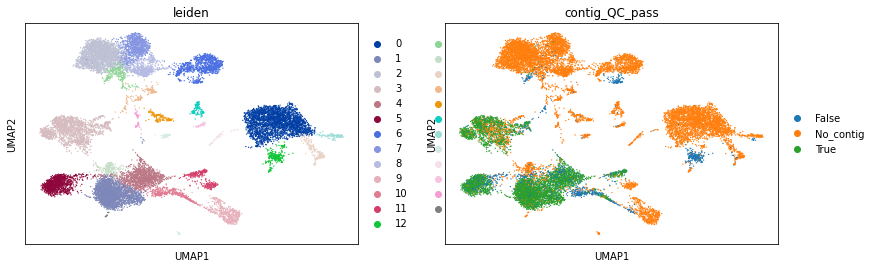

In [25]:
sc.pl.umap(adata, color=['leiden', 'contig_QC_pass'])

**Visualizing some T cell genes.**

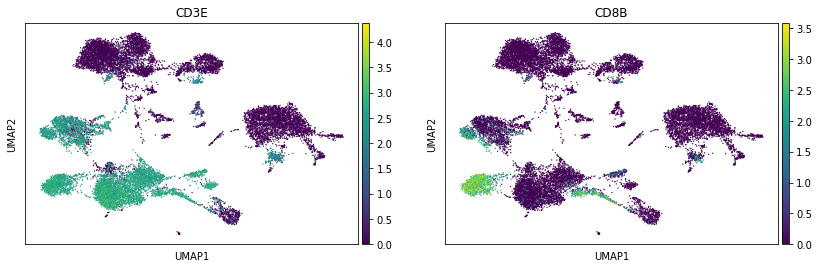

In [26]:
sc.pl.umap(adata, color=['CD3E', 'CD8B'])

**Find clones.**

<div class="alert alert-info">

Note

Here we specify `identity = 1` so only cells with identical CDR3 nucleotide sequences (`key = 'junction'`) are grouped into clones/clonotypes.

</div>

In [28]:
ddl.tl.find_clones(vdj, identity = 1, key = 'junction')
vdj

Finding clones based on abT cell VDJ chains : 100%|██████████| 501/501 [00:00<00:00, 1515.93it/s]                                                
Refining clone assignment based on VJ chain pairing : 100%|██████████| 5336/5336 [00:00<00:00, 329202.12it/s]                                    


Dandelion class object with n_obs = 5336 and n_contigs = 10357
    data: 'cell_id', 'sequence_id', 'sequence', 'sequence_aa', 'productive', 'rev_comp', 'v_call', 'v_cigar', 'd_call', 'd_cigar', 'j_call', 'j_cigar', 'c_call', 'c_cigar', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'junction_length', 'junction_aa_length', 'v_sequence_start', 'v_sequence_end', 'd_sequence_start', 'd_sequence_end', 'j_sequence_start', 'j_sequence_end', 'c_sequence_start', 'c_sequence_end', 'consensus_count', 'duplicate_count', 'is_cell', 'locus', 'rearrangement_status', 'sample_id', 'clone_id'
    metadata: 'clone_id', 'clone_id_by_size', 'sample_id', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_abT_VDJ', 'd_call_abT_VDJ', 'j_call_abT_VDJ', 'v_call_abT_VJ', 'j_call_abT_VJ', 'productive_abT_VDJ', 'p

**Generate TCR network.**

The 10x-provided AIRR file is missing columns like `sequence_alignment` and `sequence_alignment_aa` so we will use the next best thing, which is `sequence` or `sequence_aa`. Note that these columns are not-gapped.

Specify `key = 'sequence_aa'` to toggle this behavior. Can also try `junction` or `junction_aa` if just want to visualise the CDR3 linkage.

In [29]:
ddl.tl.generate_network(vdj, key = 'sequence_aa')

Setting up data: 10357it [00:01, 5435.37it/s]
Linking edges : 100%|██████████| 5286/5286 [00:00<00:00, 67821.41it/s]                                                                           


In [30]:
vdj

Dandelion class object with n_obs = 5336 and n_contigs = 10357
    data: 'cell_id', 'sequence_id', 'sequence', 'sequence_aa', 'productive', 'rev_comp', 'v_call', 'v_cigar', 'd_call', 'd_cigar', 'j_call', 'j_cigar', 'c_call', 'c_cigar', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'junction_length', 'junction_aa_length', 'v_sequence_start', 'v_sequence_end', 'd_sequence_start', 'd_sequence_end', 'j_sequence_start', 'j_sequence_end', 'c_sequence_start', 'c_sequence_end', 'consensus_count', 'duplicate_count', 'is_cell', 'locus', 'rearrangement_status', 'sample_id', 'clone_id'
    metadata: 'clone_id', 'clone_id_by_size', 'sample_id', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_abT_VDJ', 'd_call_abT_VDJ', 'j_call_abT_VDJ', 'v_call_abT_VJ', 'j_call_abT_VJ', 'productive_abT_VDJ', 'p

**Plotting in `scanpy`.**

In [31]:
ddl.tl.transfer(adata, vdj) # this will include singletons. To show only expanded clones, specify expanded_only=True

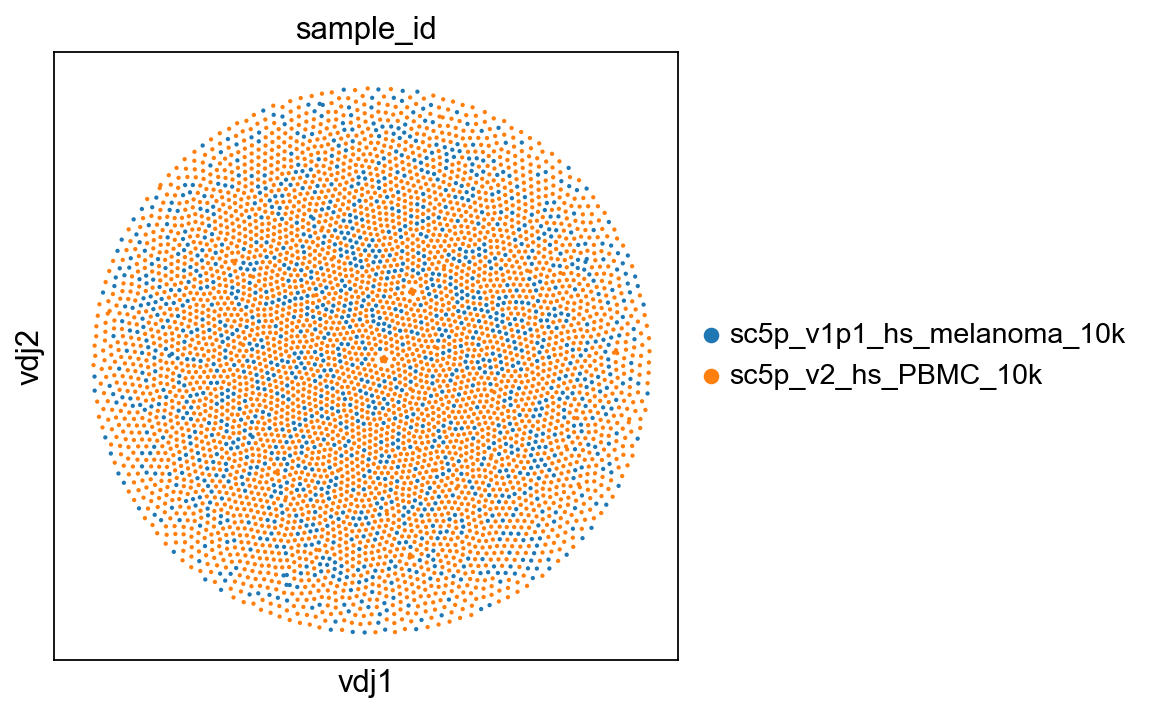

In [34]:
sc.set_figure_params(figsize = [5,5])
ddl.pl.clone_network(adata, 
                     color = ['sample_id'], 
                     edges_width = 1, size = 15) 

In [39]:
adata

AnnData object with n_obs × n_vars = 17275 × 2305
    obs: 'sample_id', 'scrublet_score', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'is_doublet', 'filter_rna', 'has_contig', 'filter_contig_quality', 'filter_contig_VDJ', 'filter_contig_VJ', 'contig_QC_pass', 'filter_contig', 'leiden', 'clone_id', 'clone_id_by_size', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_abT_VDJ', 'd_call_abT_VDJ', 'j_call_abT_VDJ', 'v_call_abT_VJ', 'j_call_abT_VJ', 'productive_abT_VDJ', 'productive_abT_VJ', 'duplicate_count_abT_VDJ', 'duplicate_count_abT_VJ', 'locus_status', 'chain_status', 'rearrangement_status_VDJ', 'rearrangement_status_VJ'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'

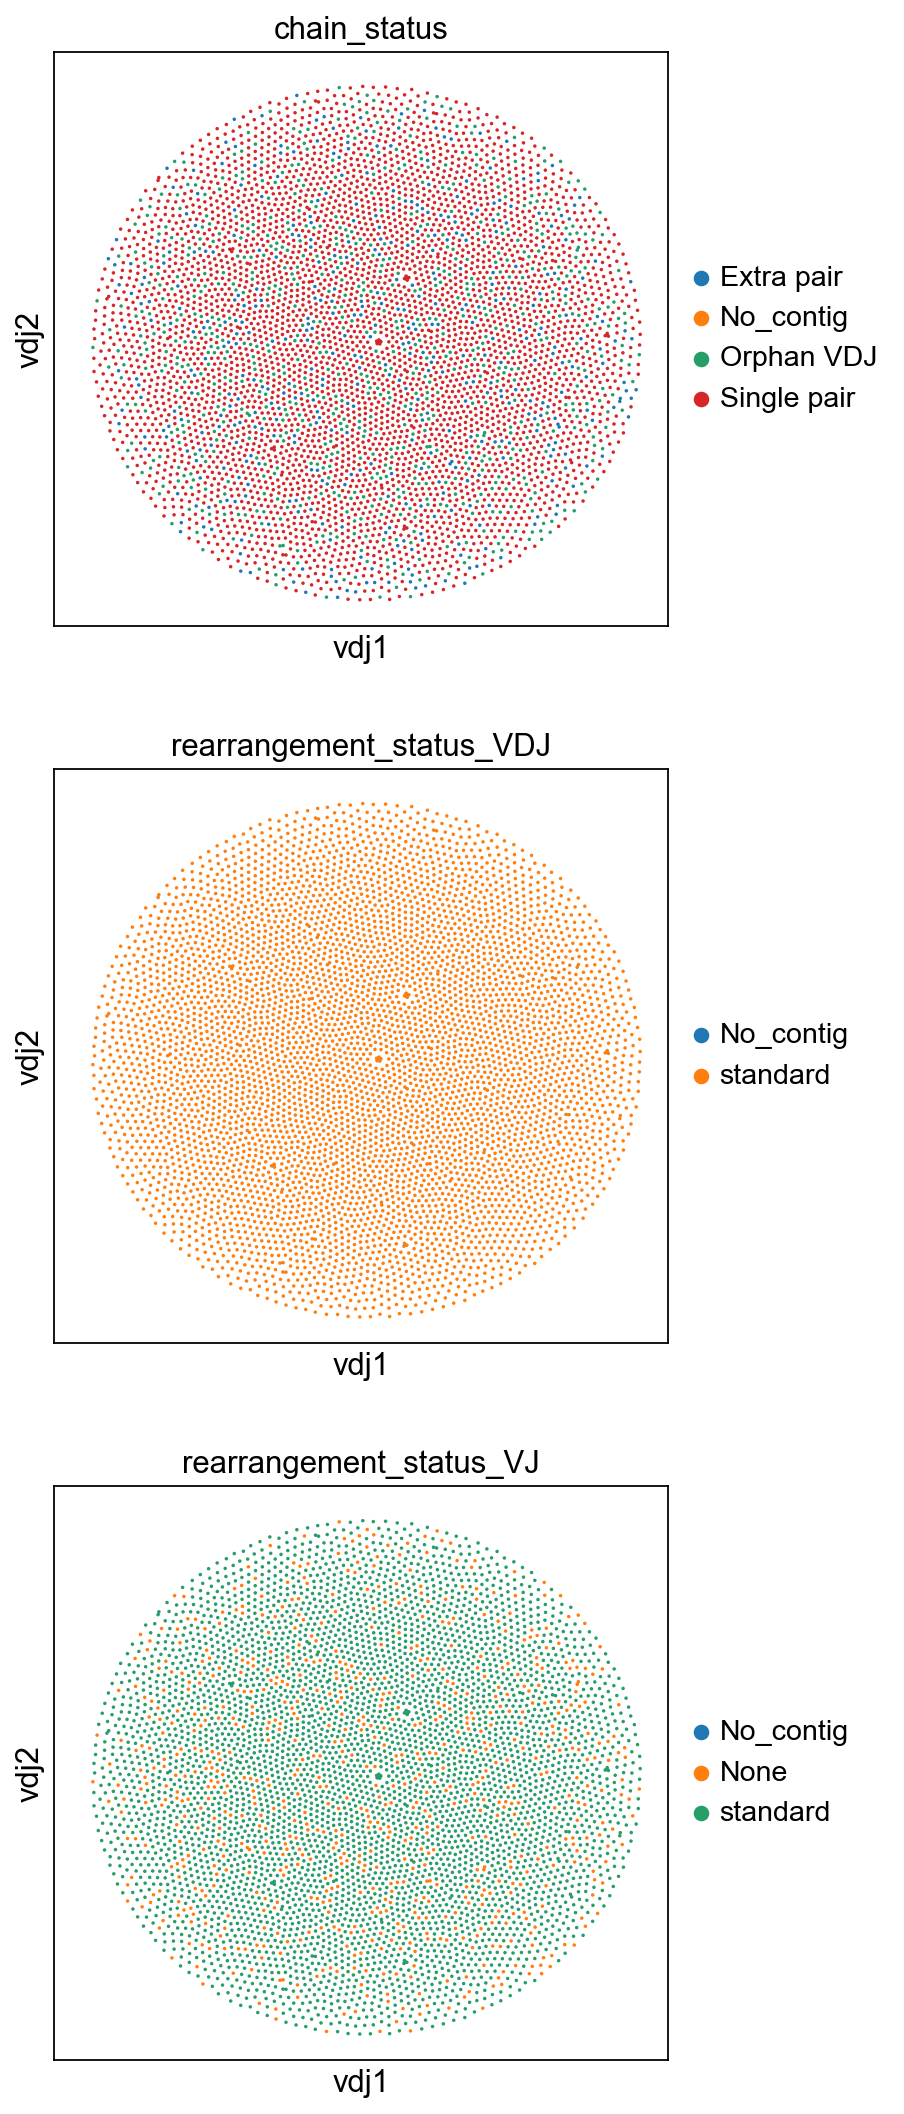

In [42]:
sc.set_figure_params(figsize = [4.5,5])
ddl.pl.clone_network(adata, 
                     color = ['chain_status', 'rearrangement_status_VDJ', 'rearrangement_status_VJ'], 
                     ncols = 1, 
                     legend_fontoutline=3,
                     size = 10,
                     edges_width = 1)

In [43]:
ddl.tl.transfer(adata, vdj, expanded_only = True)

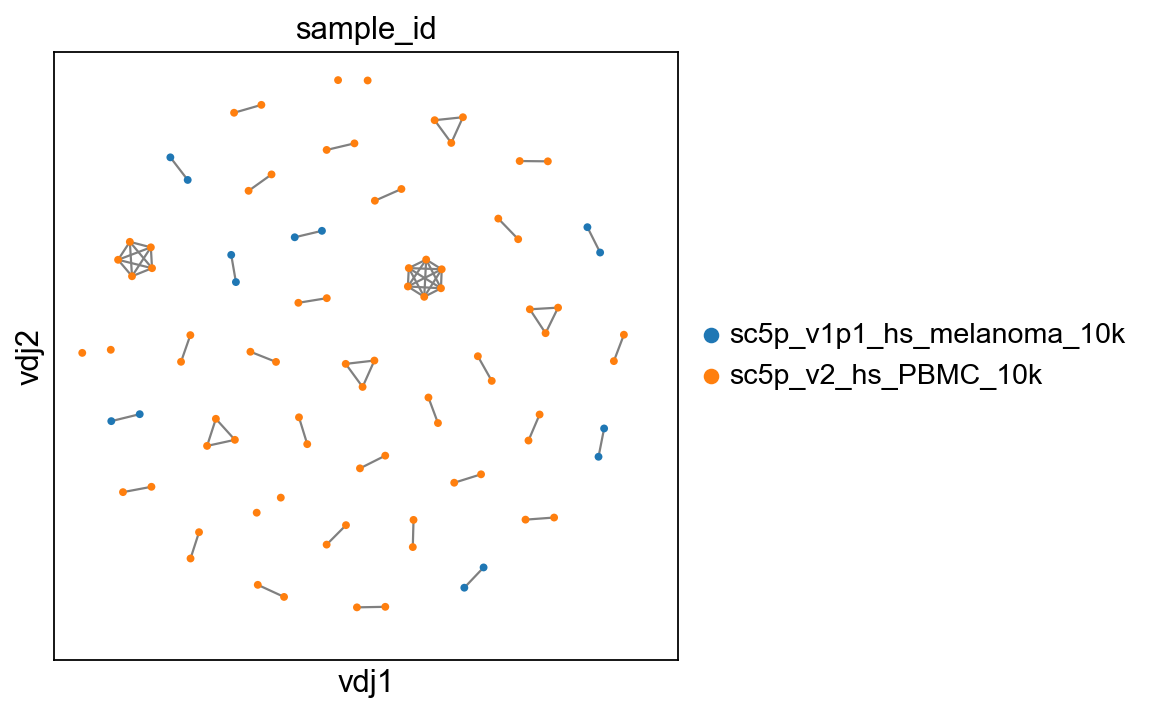

In [44]:
sc.set_figure_params(figsize = [5,5])
ddl.pl.clone_network(adata, 
                     color = ['sample_id'], 
                     edges_width = 1,
                     size = 50) 

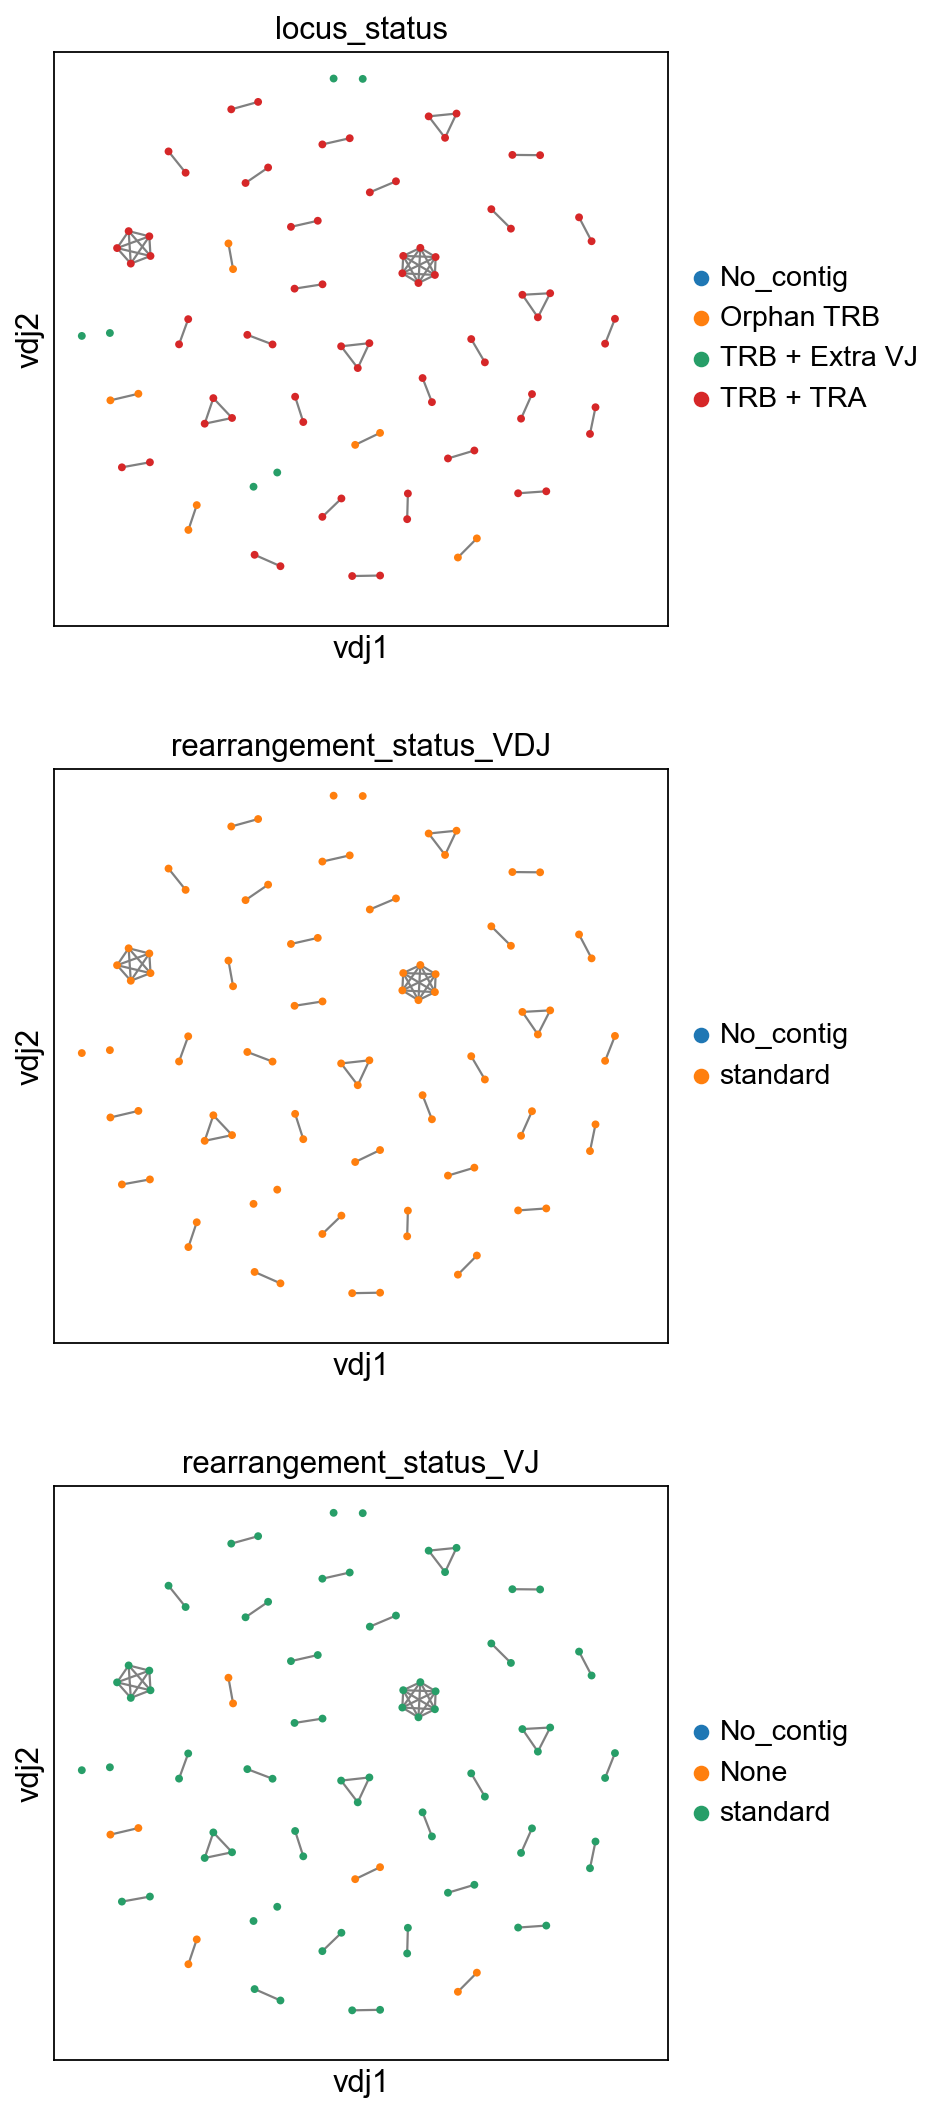

In [47]:
sc.set_figure_params(figsize = [4.5,5])
ddl.pl.clone_network(adata, 
                     color = ['locus_status', 'rearrangement_status_VDJ', 'rearrangement_status_VJ'], 
                     ncols = 1, 
                     legend_fontoutline=3, 
                     edges_width = 1,
                     size = 50)

### Using `scirpy` to plot
You can also use `scirpy`'s functions to plot the network. 

A likely use case is if you have a lot of cells and you don't want to wait for `dandelion` to generate the layout because it's taking too long. Or you simply prefer scirpy's style of plotting.

You can run `ddl.tl.generate_network(..., generate_layout = False)` and it will finish ultra-fast, and after transfer to `scirpy`, you can use its plotting functions to visualise the networks - the clone network is generated very quickly but visualising it using spring layout does take quite a while.

<AxesSubplot:>

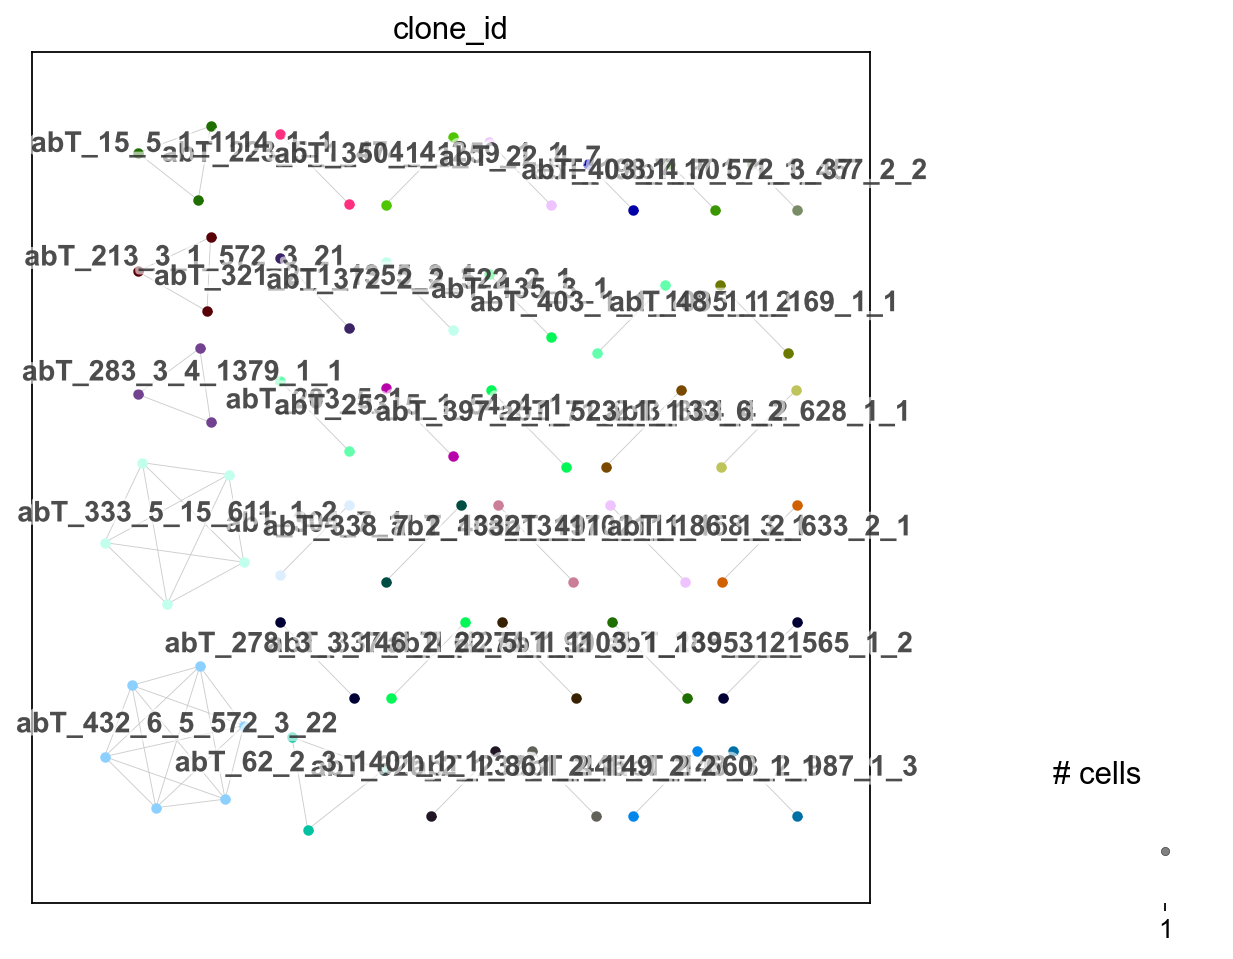

In [48]:
import scirpy as ir
ir.tl.clonotype_network(adata, min_cells = 2)
ir.pl.clonotype_network(adata, color = 'clone_id', panel_size=(7, 7))

You can change the clonotype labels by transferring with a different `clone_key`. For example, from numerically ordered from largest to smallest.

<AxesSubplot:>

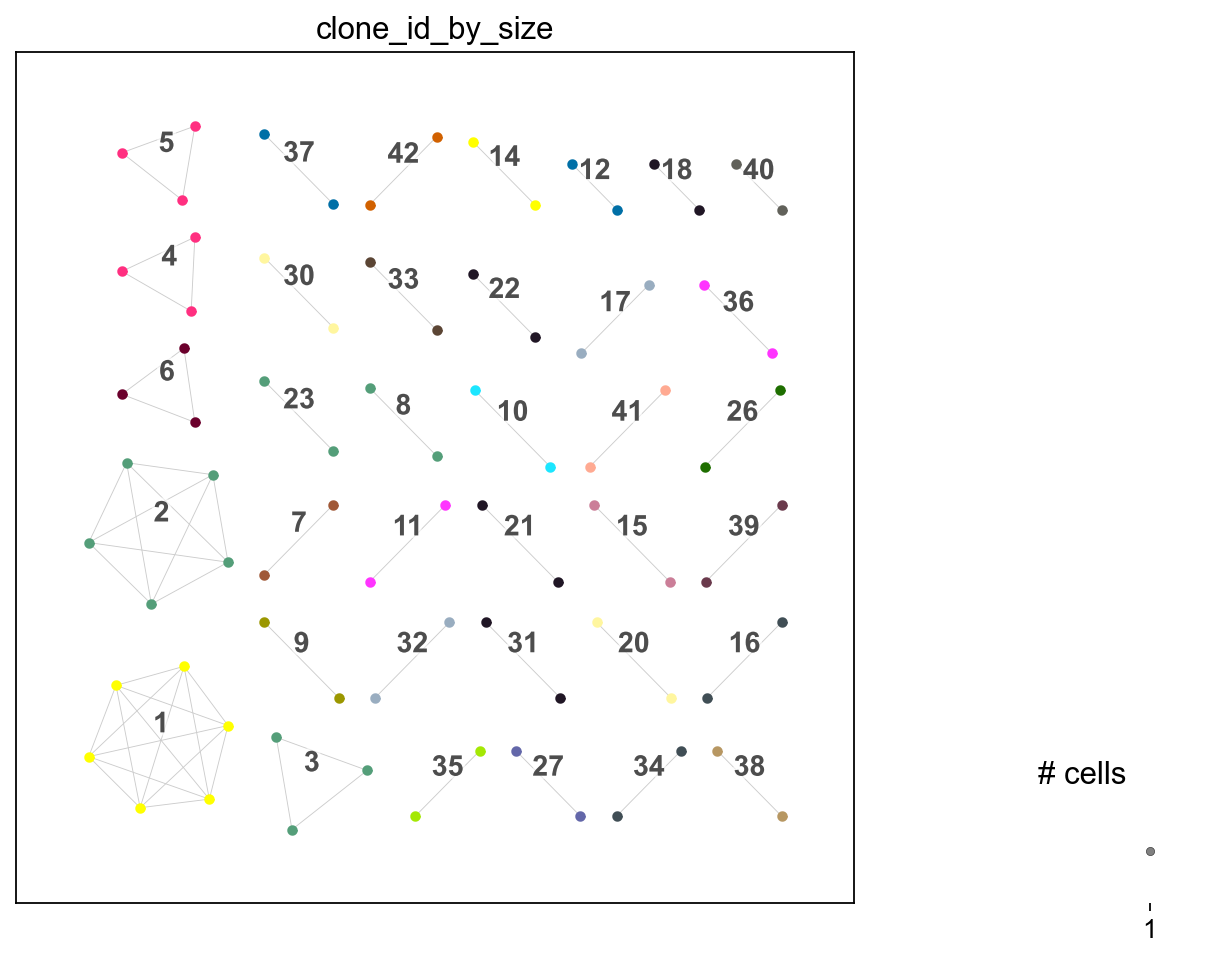

In [49]:
ddl.tl.transfer(adata, vdj, clone_key = 'clone_id_by_size')
ir.tl.clonotype_network(adata, clonotype_key = 'clone_id_by_size', min_cells = 2)
ir.pl.clonotype_network(adata, color = 'clone_id_by_size', panel_size=(7, 7))

You can also transfer with the clones collapsed for plotting as pie-charts as per how `scirpy` does it.

<AxesSubplot:>

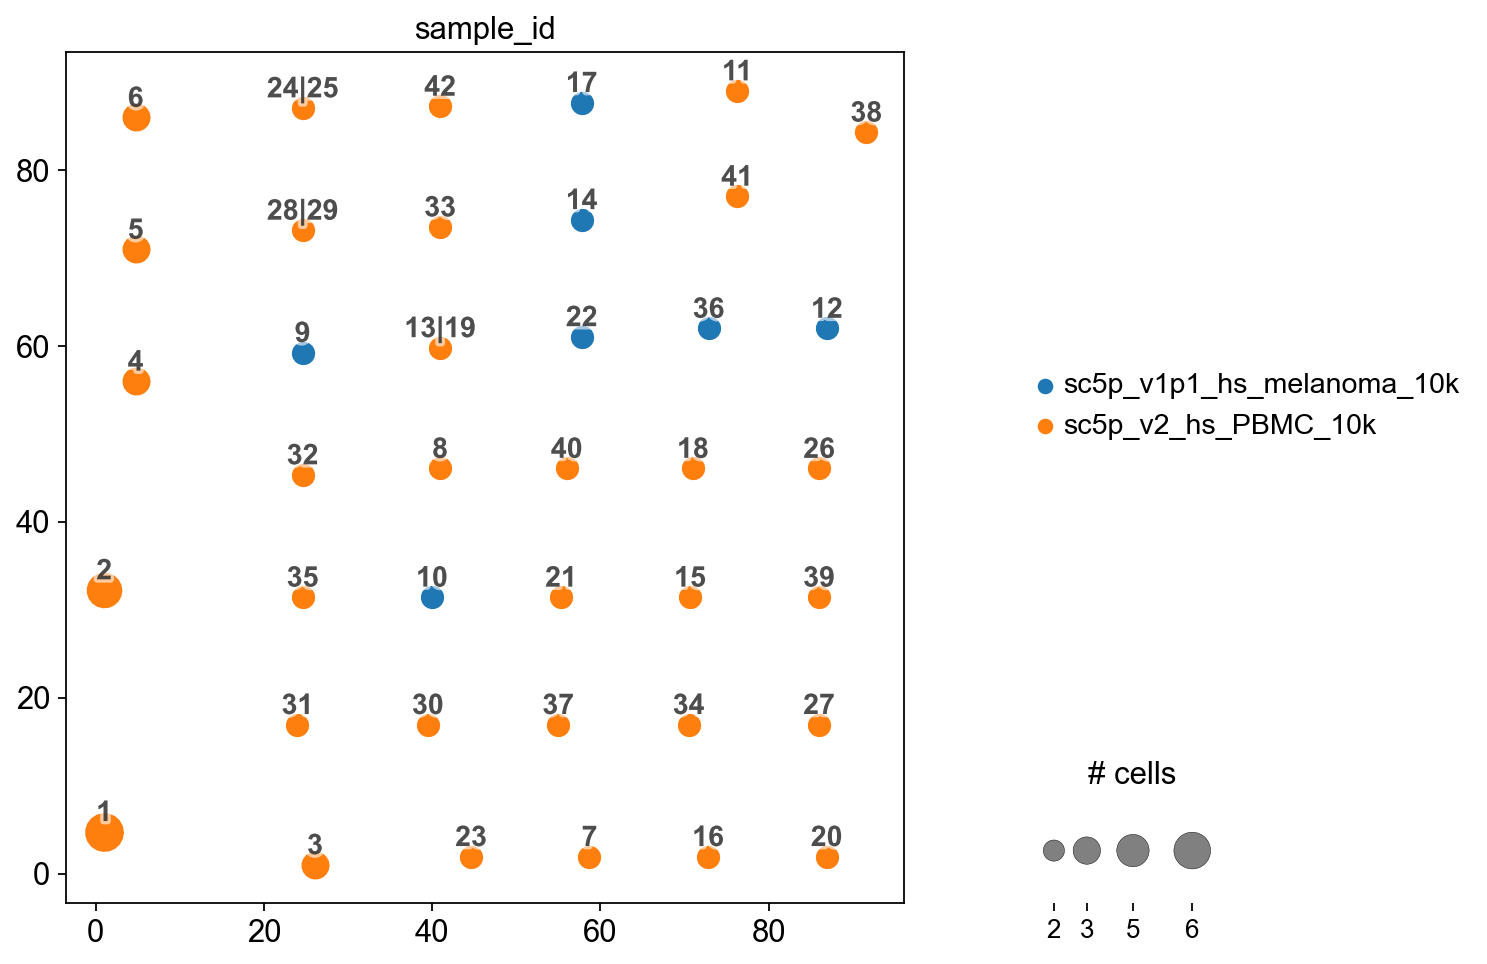

In [50]:
ddl.tl.transfer(adata, vdj, clone_key = 'clone_id_by_size', collapse_nodes = True)
ir.tl.clonotype_network(adata, clonotype_key = 'clone_id_by_size', min_cells = 2)
ir.pl.clonotype_network(adata, color = 'sample_id', panel_size=(7, 7))

**Finish.**

We can save the files.

In [51]:
adata.write('adata_tcr.h5ad', compression = 'gzip')

In [52]:
vdj.write_h5ddl('dandelion_results_tcr.h5ddl', complib = 'blosc:lz4')